In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [4]:

from samplers.rbf_ecp_marginal import RBFSolverECPMarginal

def get_w(lambda_s, lambda_t, lambdas, x_theta_hist, beta):
    lambda_s = lambda_s.to(torch.float64)
    lambda_t = lambda_t.to(torch.float64)
    lambdas = lambdas.to(torch.float64)
    beta = beta.to(torch.float64)
    x_theta_hist = x_theta_hist.to(torch.float64)
    p = len(lambdas)

    # (p,)
    # x_theta_hist
    # (1,)
    x_theta_zeros = torch.zeros_like(x_theta_hist[:1])
    
    # (p+1,)
    x_theta_aug = torch.cat([x_theta_hist, x_theta_zeros], dim=0)
    # (p, p)
    kernel = RBFSolverECPMarginal.get_kernel_matrix(None,lambdas, beta)
    eye = torch.eye(p+1, device=kernel.device).to(torch.float64)
    kernel_aug = 1 - eye
    kernel_aug[:p, :p] = kernel
    # (p,)
    ws = torch.linalg.solve(kernel_aug, x_theta_aug)
    # ws = ws[:p]  # (p+1,) 중 앞 p개만 슬라이싱
    return ws.float()

def rbf_interpolation(gammas, target_step, ts_reverse, center_hist, ts_ref):
    i = target_step
    beta = 1/(np.exp(gammas[0][i])*abs(ts_reverse[i+1]-ts_reverse[i]))
    center_hist_p = torch.flip(center_hist[i-p+1:i+1], dims=[0])
    ts_reverse_p = torch.flip(ts_reverse[i-p+1:i+1], dims=[0])

    def get_weighted_kernel(ts, w):
        return w[:,None].T*torch.exp(-beta**2 * (ts[:,None] - ts_reverse_p[:,None].T) ** 2)

    ws = get_w(ts_reverse[i], ts_reverse[i+1], ts_reverse_p, center_hist_p, beta)

    wk = get_weighted_kernel(ts_ref,ws[:-1])
    
    return wk, ws[-1]

In [5]:
import matplotlib.pyplot as plt
from cycler import cycler

# ── 전역 스타일 (이미 한 번만 실행해 두면 이후엔 생략 가능) ──────────────────
plt.rcParams.update({
    'figure.figsize'     : (6, 4.2),     # 기본 크기
    'font.size'          : 12,
    'axes.titlesize'     : 14,
    'axes.labelsize'     : 12,
    'xtick.labelsize'    : 10,
    'ytick.labelsize'    : 10,
    'legend.fontsize'    : 10,
    'axes.grid'          : True,
    'grid.linestyle'     : '--',
    'grid.alpha'         : 0.6,
    'axes.spines.top'    : False,
    'axes.spines.right'  : False,
    # Color-blind friendly 4-색 순환
    'axes.prop_cycle'    : cycler(color=['#0072B2','#D55E00','#009E73','#CC79A7']),
    'xtick.direction'    : 'out',
    'ytick.direction'    : 'out',
})

# ────────────────────────────────────────────────────────────────────────
def plot_graph(center_hist, lambdas, lambdas_ref, b, target_step, gammas):
    """
    RBF 기반 예측 vs. GT 시각화
    """
    wk, w_const = rbf_interpolation(
        gammas, target_step, lambdas, center_hist, lambdas_ref[:-1]
    )

    fig, ax = plt.subplots()

    # ① 예측값 (scatter)
    ax.scatter(
        lambdas[:-1], center_hist,
        marker='o', s=40, color='black', zorder=3,
        label=r'$x_0$ prediction'
    )

    # ② 개별 RBF kernel (얇은 점선)
    wk_sum = torch.zeros_like(wk[:, 0])
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for idx in range(3):
        ax.plot(
            lambdas_ref[:-1], wk[:, idx],
            linestyle='--', linewidth=1.2, alpha=0.55,
            color=colors[idx],
        )
        wk_sum += wk[:, idx]

    # ③ 상수항
    ax.hlines(
        y=w_const,
        xmin=lambdas_ref[0].item(), xmax=lambdas_ref[-1].item(),
        linestyle=':', linewidth=1.2, alpha=0.55
    )
    wk_sum += w_const

    # ④ 최종 RBF 합성곡선
    ax.plot(
        lambdas_ref[:-1], wk_sum,
        linewidth=3, color=colors[3], label='RBF Interpolation'
    )

    # ── 그래프 서식 ──────────────────────────
    ax.set_xlabel('time')
    ax.set_ylabel('value')
    ax.set_title(f'{b} – RBF Interpolation')
    #ax.legend(frameon=False, loc='best')
    ax.grid(axis='y')                    # y-축 격자만 활성 (선택)
    plt.tight_layout()
    plt.show()


def show_x_thetas(imgs):
    n = imgs.shape[0]
    imgs = imgs/2.0 + 0.5
    grid = make_grid(imgs, nrow=n, padding=0)
    plt.figure(figsize=(8, 8/n))                   # width=8inch, height는 자동 비율
    plt.axis("off")
    plt.imshow(np.clip(grid.permute(1, 2, 0).cpu().numpy(),0,1))  # C,H,W → H,W,C 로 변환 후 NumPy
    plt.tight_layout()
    plt.show()

def get_center_traj(model_hist, bn, cn):
    b, c, w, h = model_hist[0].shape
    x0_traj = []
    for i in range(len(model_hist)):
        if model_hist[i] is None:
            continue
        x0_traj.append(model_hist[i][bn,cn,int(w/2),int(h/2)].item())
    return torch.Tensor(x0_traj)

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import torch                                 # rbf_interpolation 필요
from matplotlib import gridspec
from torchvision.utils import make_grid      # imgs가 텐서일 때만 사용

def plot_graph_with_imgs(center_hist, lambdas, lambdas_ref,
                         b, target_step, gammas,
                         imgs,                        # (n, C, H, W) tensor, value range [-1, 1]
                         times):                      # ex) [0.0, 0.2, …, 1.0]

    # ── RBF 계산 ────────────────────────────────────────
    wk, w_const = rbf_interpolation(
        gammas, target_step, lambdas, center_hist, lambdas_ref[:-1]
    )

    # ── Figure / GridSpec ───────────────────────────────
    fig = plt.figure(figsize=(8, 6))
    gs  = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

    # ── 1) 선 그래프 (상단) ─────────────────────────────
    ax = fig.add_subplot(gs[0])

    # 빈 점(0,4,5)·채운 점 분리
    hollow_idx = {0, 4, 5}
    filled_x   = [x for i, x in enumerate(lambdas[:-1]) if i not in hollow_idx]
    filled_y   = [center_hist[i] for i in range(len(center_hist)) if i not in hollow_idx]
    hollow_x   = [x for i, x in enumerate(lambdas[:-1]) if i in hollow_idx]
    hollow_y   = [center_hist[i] for i in hollow_idx]

    ax.scatter(filled_x, filled_y, marker='o', s=40, color='black', zorder=3, label='Model Evaluations')
    ax.scatter(hollow_x, hollow_y, marker='o', s=40, color='black', zorder=3, alpha=0.3)

    # tab10 팔레트 사용
    colors = plt.get_cmap('tab10').colors
    wk_sum = torch.zeros_like(wk[:, 0])
    for idx in range(3):
        ax.plot(lambdas_ref[:-1], wk[:, idx],
                ls='-', lw=1.2, color=colors[idx], label=f'RBF Basis {idx}')
        wk_sum += wk[:, idx]

    ax.hlines(w_const, lambdas_ref[0].item(), lambdas_ref[-1].item(),
              ls='-', lw=1.2, color=colors[3], label='Const. Basis')
    wk_sum += w_const

    ax.plot(lambdas_ref[:-1], wk_sum,
            lw=3, color=colors[0], label='RBF Interpolation')

    # 축 설정
    ax.set_ylabel('pixel value')
    ax.set_xlim(times[0], times[-1])
    ax.set_xticks([])                          # x축 눈금 숨김
    ax.set_yticks([-0.5, 0.0, 0.5, 1.0])       # y축 눈금 고정
    ax.set_ylim([-1.0, 1.2])
    ax.legend(frameon=False, loc='lower right')

    # filled_x 위치에, 해당 점까지 세로 가이드라인
    y0, _ = ax.get_ylim()
    for x, y in zip(filled_x, filled_y):
        ax.vlines(x, y0, y,
                  colors='grey', linestyles='--', linewidth=1.2, alpha=0.6, zorder=0)

    # ── 2) 이미지 스트립 (하단) ─────────────────────────
    ax_img = fig.add_subplot(gs[1])
    gaps = np.diff(times)
    gaps = np.append(gaps, gaps[-1])

    for i, img in enumerate(imgs):
        img_np = np.clip((img / 2 + 0.5).permute(1, 2, 0).cpu().numpy(), 0, 1)
        left, right = times[i], times[i] + gaps[i]
        ax_img.imshow(img_np, extent=[left, right, 0, 1], aspect='auto')

    # step 라벨링
    steps  = np.arange(len(times))
    labels = [rf'$t_{i}$' for i in steps]
    ax_img.set_yticks([])
    ax_img.set_xticks(times)
    ax_img.set_xticklabels(labels)
    ax_img.set_xlabel('step')
    ax_img.tick_params(axis='x', length=0)
    for spine in ax_img.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.show()


In [37]:
# 1 : goldfish, 4.0
# 279: arctic fox, 6.0
# 323: monarch butterfly, 8.0
# 386: african elephant, 8.0
# 130: flamingo, 6.0
# 852: tennis ball, 4.0
# 933: cheeseburger, 6.0
# 562: fountain, 6.0
# 417: balloon, 6.0
# 281: tabby cat, 6.0
# 90:lorikeet, 6.0
# 992: agaric 4.0

In [38]:
p = 3
steps = 6
class_int = 263
gammas = np.load(f"/data/guided-diffusion/scale/rbf_ecp_marginal4.0_128/NFE={steps},p={p}.npz")['optimal_log_scales']
loaded_npz = np.load(f'plot_data_step{steps}_class{class_int}.npz')

In [39]:

model_hist = torch.Tensor(loaded_npz['model_hist'])
print(model_hist.shape)

lambdas = torch.Tensor(loaded_npz['lambdas'])
ts = torch.Tensor(loaded_npz['ts'])

# reverse time axis for plotting...
ts_reverse = torch.Tensor([1-t for t in ts])

ts_ref = torch.arange(0, 1, 1/1000)

torch.Size([6, 49, 3, 128, 128])


/tmp/ipykernel_567998/1408142558.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


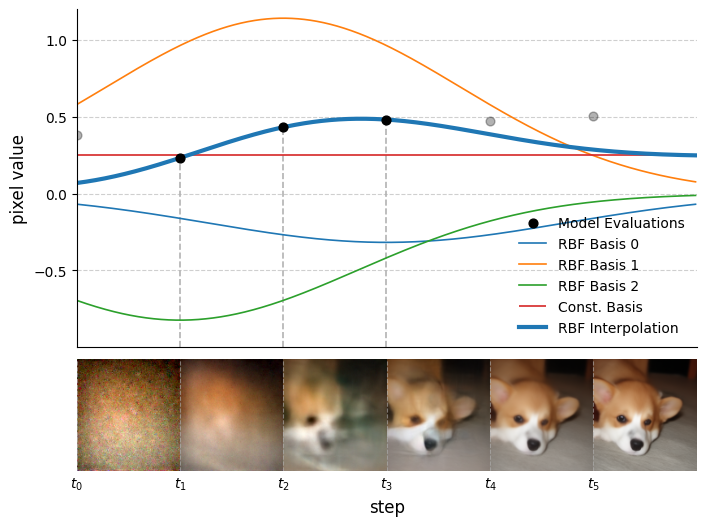

In [40]:
target_step = 3

#for b in range(model_hist.shape[1]):
b = 46
for c in [1]:
    center_hist = get_center_traj(model_hist, b, c)
    #plot_graph(center_hist, ts_reverse, ts_ref, b, target_step, gammas)
    plot_graph_with_imgs(center_hist, ts_reverse, ts_ref,
                        b, target_step, gammas,
                        model_hist[:,b],
                        [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
#show_x_thetas(model_hist[:,b])